# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

According to <b>Materials and Methods</b> section, the dataset collected is related to <b>17 campaigns</b> that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts. There was <b>8% (6499)</b> success rate out of the campaign outreach.

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
%%capture
%pip install plotly
%pip install matplotlib
%pip install pandas
%pip install seaborn
%pip install numpy
%pip install scikit-learn
%pip install category_encoders
%pip install IPython
%pip install graphviz
%pip install tabulate

In [2]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, PolynomialFeatures, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import roc_curve, precision_recall_curve, roc_auc_score, confusion_matrix
from sklearn.metrics import classification_report, auc,PredictionErrorDisplay, mean_squared_error, f1_score, recall_score 
from sklearn.compose import ColumnTransformer, make_column_transformer

In [3]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [4]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Utility functions
# Wrap labels for x-axis
def wrap_labels(ax, width, n, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width, break_long_words=break_long_words))
    ax.set_xticks(np.arange(0, n, 1))
    ax.set_xticklabels(labels, rotation=0)

# Get unique values for each column
def get_unique_values(df):
    for col in df.columns:
        unique_values = df[col].unique()
        print(f'Unique values for {col}: {unique_values}\n')

# Get unique values for each column
def get_value_counts(df):
    for col in df.columns:
        value_counts = df[col].value_counts()
        print(f'Value counts for {col}: {value_counts}\n')

def autopct_format(values):
        def _format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            if pct < 2:
                return '{:.2f}%'.format(pct, v=val)
            return '{:.2f}%\n({v:d})'.format(pct, v=val)
        return _format
    
def show_confusion_matrix(y_test, preds):
    disp = ConfusionMatrixDisplay.from_predictions(y_test, preds)
    cm = disp.confusion_matrix
    ax = disp.ax_
    
    # Annotate TP, FP, FN, TN
    labels = np.array([["TN", "FP"], ["FN", "TP"]])
    for i in range(2):
        for j in range(2):
            ax.text(j, i, f"{labels[i, j]}\n", 
                    ha="center", va="bottom", color="black", fontsize=12)

def show_metrics_curve(model):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    preds_proba = model.predict_proba(X_test)
    yes_probs = preds_proba[::,1]
    
    # Build confusion metrics for Yes
    roc_yes_fp, roc_yes_tp, roc_yes_threshold = roc_curve(y_true=y_test,  y_score=yes_probs, pos_label=1)
    roc_no_fp, roc_no_tp, roc_no_threshold = roc_curve(y_true=y_test,  y_score=yes_probs, pos_label=0)

    prec_yes_fp, prec_yes_tp, prec_yes_threshold = precision_recall_curve(y_true=y_test,  y_score=yes_probs, pos_label=1)
    prec_no_fp, prec_no_tp, prec_no_threshold = precision_recall_curve(y_true=y_test,  y_score=yes_probs, pos_label=0)
    
    #create Metrics (ROC & Precision-Recall) curve
    axes[0].plot(roc_yes_fp, roc_yes_tp, label="Yes")
    axes[0].plot(roc_no_fp, roc_no_tp, label="No")
    axes[1].plot(prec_yes_fp, prec_yes_tp, label="Yes")
    axes[1].plot(prec_no_fp, prec_no_tp, label="No")
    
    axes[0].legend(loc="upper left")
    axes[1].legend(loc="upper left")
    axes[0].set_title('ROC Curve', size=12)
    axes[1].set_title('Precision-Recall Curve', size=12)
    axes[0].plot([0, 1], [0, 1], color='green', linestyle=':')
    axes[1].plot([0, 1], [0, 1], color='green', linestyle=':')
    axes[0].set_ylabel('True Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[0].set_xlabel('False Positive Rate')
    axes[1].set_xlabel('False Positive Rate')

def print_auc(model):
    preds_proba = model.predict_proba(X_test)
    yes_probs = preds_proba[::,1]
    auc = roc_auc_score(y_true=y_test, y_score=yes_probs)
    print("Area under curve is {:.6f}".format(round(auc, 2)))

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [7]:
df.shape

(41188, 21)

In [8]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [10]:
get_unique_values(df)

Unique values for age: [56 57 37 40 45 59 41 24 25 29 35 54 46 50 39 30 55 49 34 52 58 32 38 44
 42 60 53 47 51 48 33 31 43 36 28 27 26 22 23 20 21 61 19 18 70 66 76 67
 73 88 95 77 68 75 63 80 62 65 72 82 64 71 69 78 85 79 83 81 74 17 87 91
 86 98 94 84 92 89]

Unique values for job: ['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Unique values for marital: ['married' 'single' 'divorced' 'unknown']

Unique values for education: ['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Unique values for default: ['no' 'unknown' 'yes']

Unique values for housing: ['no' 'yes' 'unknown']

Unique values for loan: ['no' 'yes' 'unknown']

Unique values for contact: ['telephone' 'cellular']

Unique values for month: ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Unique values for day_of_week: ['mon' 'tue' 'wed' 'thu' '

In [11]:
# rename column 'y' to meaningful name
df.rename(columns={'y': 'deposit'}, inplace=True)
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [12]:
# Countplot for categorical features
def plot_distribution_by_category(x, df, category_name, hue='deposit', w=10, h=6):
    plt.rcParams['figure.figsize'] = [w, h]
    plt.rcParams['figure.autolayout'] = True
  
    ax = sns.countplot(x=x, hue=hue, data=df)
    ax.set_title(f"Bar plot for deposit acceptance by {category_name}")
    for p in ax.patches:
        ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x() + 0.2, p.get_height()), ha='center', va='bottom')
                    # arrowprops=dict(facecolor='red', shrink=0.05))

    ax.set_xlabel(category_name)
    ax.set_ylabel('Count')
    plt.xticks(rotation=90)
    plt.savefig(f'data/bar_plot_by_{x}')
    plt.show()

In [13]:
# Plot some pie charts to visualize the number of accepted term deposits by loan types in dataset    
def pie_plot_deposit_acceptance_by_category(df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    (ax1, ax2, ax3, ax4) = axes.flatten()

    ax1.set_title('Pie Chart - Housing Loan')
    housing_counts = df['housing'].value_counts()
    ax1.pie(housing_counts, labels=housing_counts.index, autopct=autopct_format(housing_counts))

    ax2.set_title('Pie Chart - Personal Loan')
    loan_counts = df['loan'].value_counts()
    ax2.pie(loan_counts, labels=loan_counts.index, autopct=autopct_format(loan_counts))

    ax3.set_title('Pie Chart - Last Contact Month')
    month_counts = df['month'].value_counts()
    ax3.pie(month_counts, labels=month_counts.index, autopct=autopct_format(month_counts))

    ax4.set_title('Pie Chart - Last Contact Week')
    day_of_week_counts = df['day_of_week'].value_counts()
    ax4.pie(day_of_week_counts, labels=day_of_week_counts.index, autopct=autopct_format(day_of_week_counts))

    plt.savefig(f'data/pie_chart_for_category_distribution.png')
    plt.show()

In [14]:
get_value_counts(df[['job', 'month', 'loan', 'education', 'marital', 'housing', 'day_of_week', 'default', 'contact']])

Value counts for job: job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

Value counts for month: month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64

Value counts for loan: loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

Value counts for education: education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

Value counts for marital: marital
married     24928
single      11568
divorced   

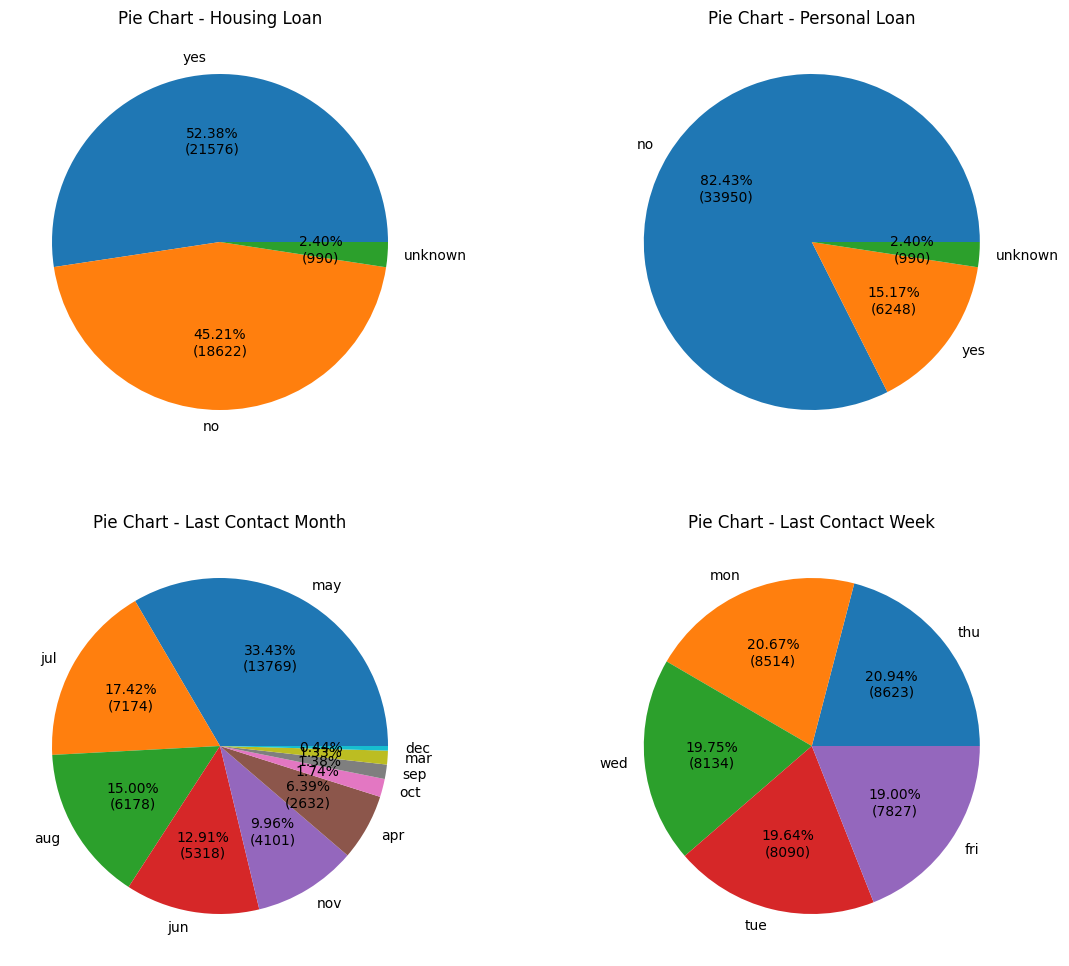

In [15]:
pie_plot_deposit_acceptance_by_category(df)

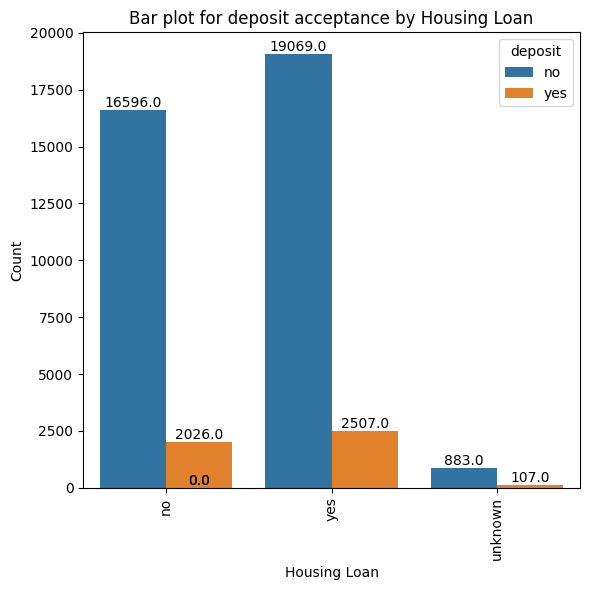

In [16]:
plot_distribution_by_category('housing', df, 'Housing Loan', w=6, h=6)

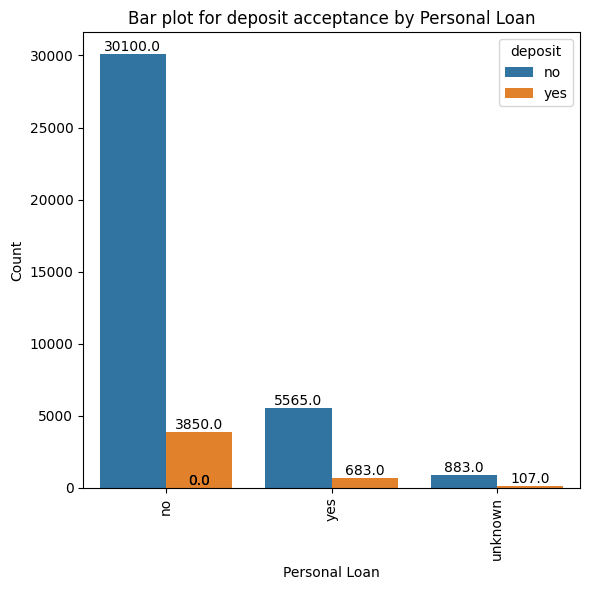

In [17]:
plot_distribution_by_category('loan', df, 'Personal Loan', w=6, h=6)

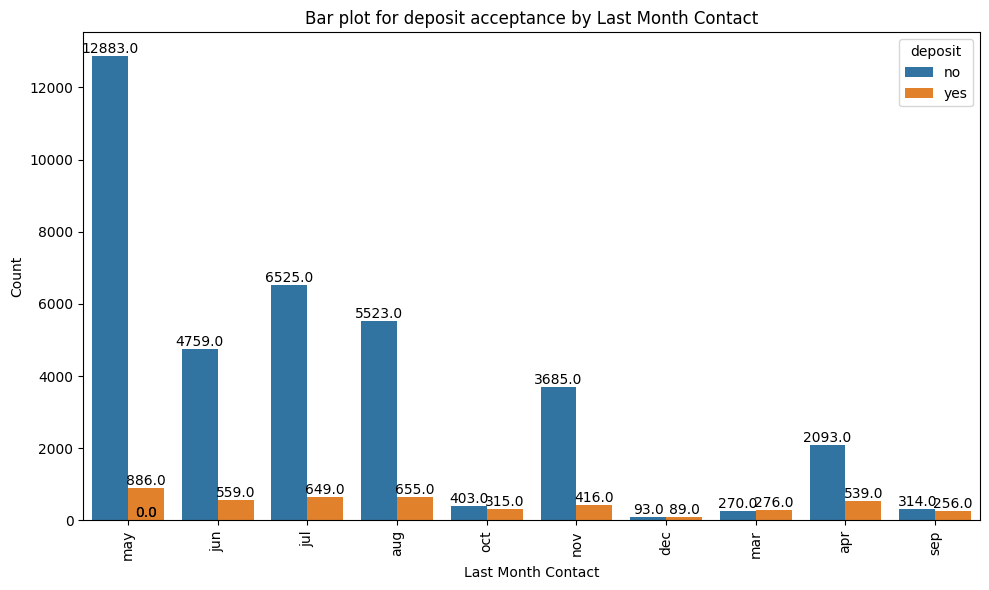

In [18]:
plot_distribution_by_category('month', df, 'Last Month Contact')

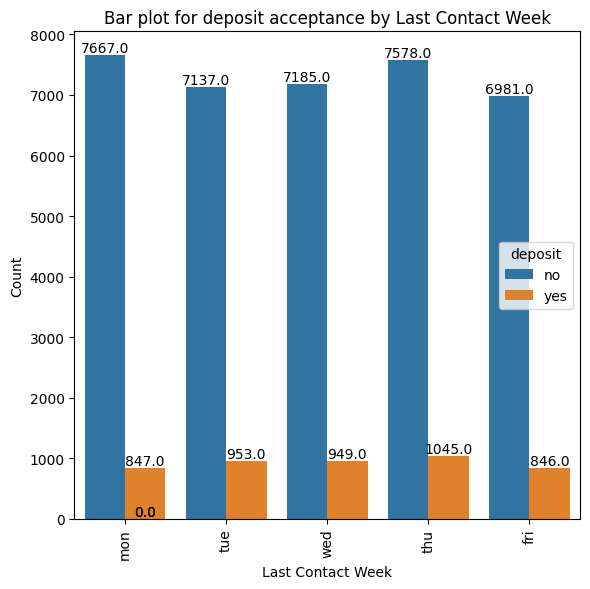

In [19]:
plot_distribution_by_category('day_of_week', df, 'Last Contact Week', w=6, h=6)

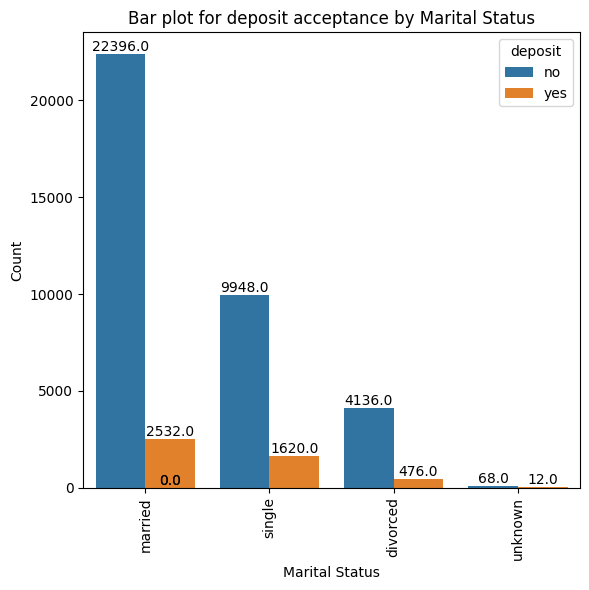

In [20]:
plot_distribution_by_category('marital', df, 'Marital Status', w=6, h=6)

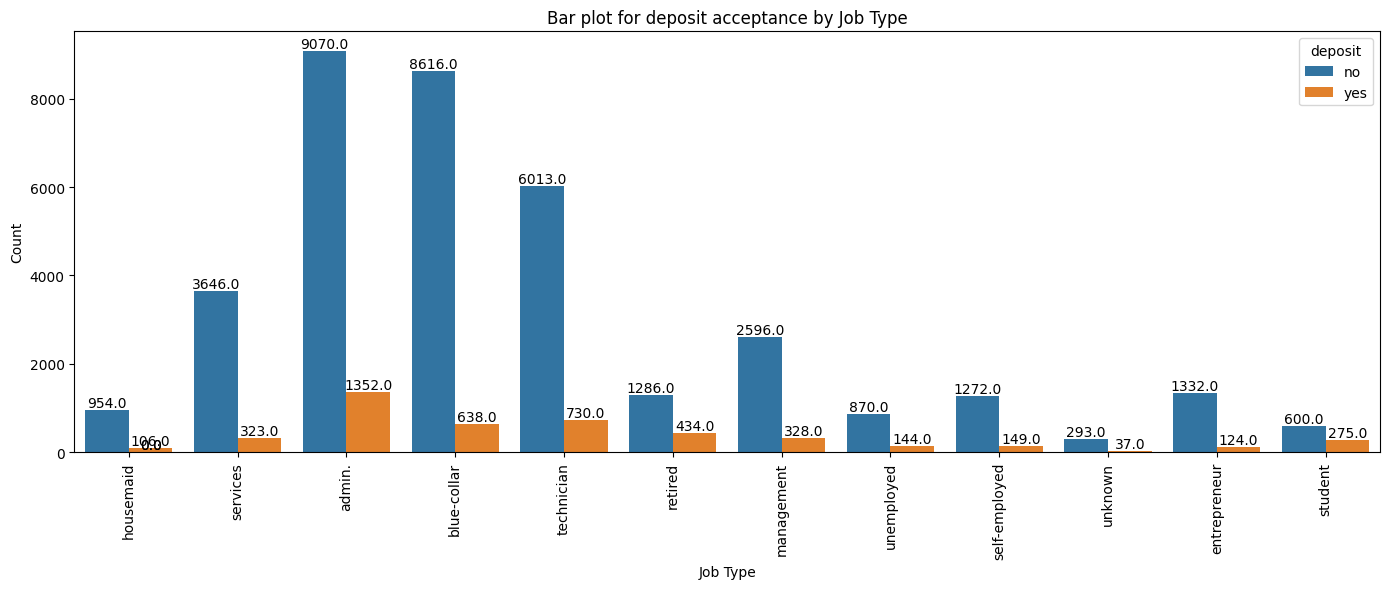

In [21]:
plot_distribution_by_category('job', df, 'Job Type', w=14)

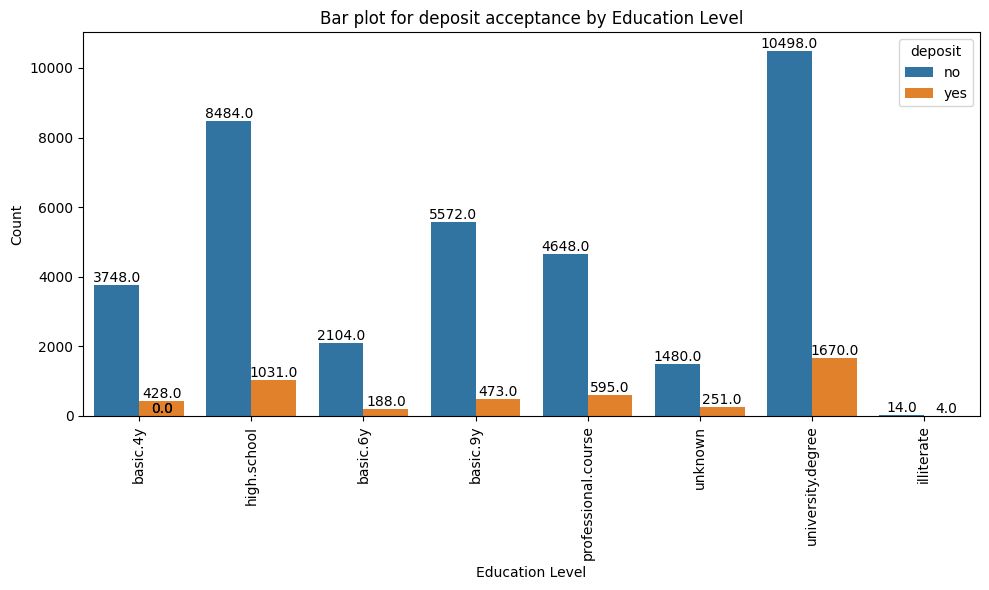

In [22]:
plot_distribution_by_category('education', df, 'Education Level')

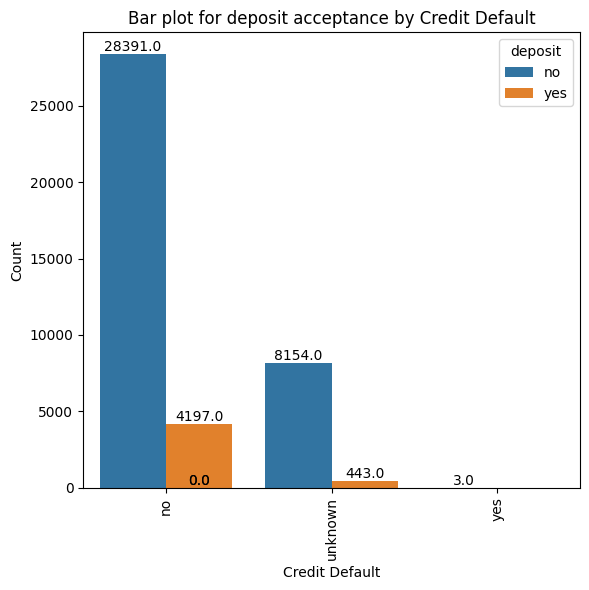

In [23]:
plot_distribution_by_category('default', df, 'Credit Default', w=6, h=6)

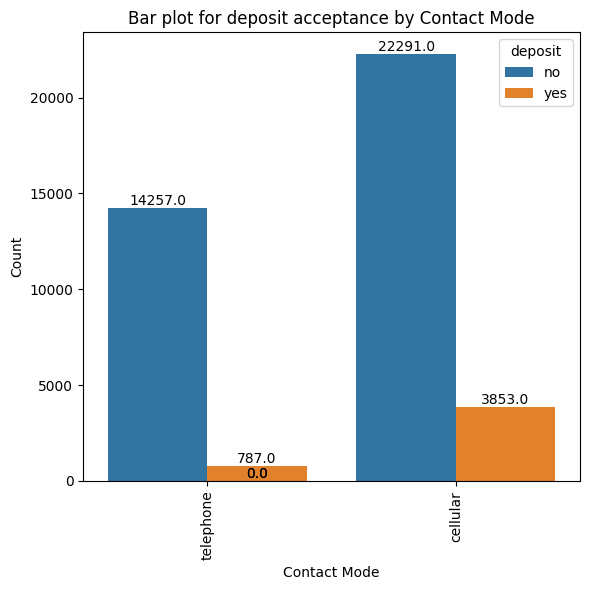

In [24]:
plot_distribution_by_category('contact', df, 'Contact Mode', w=6, h=6)

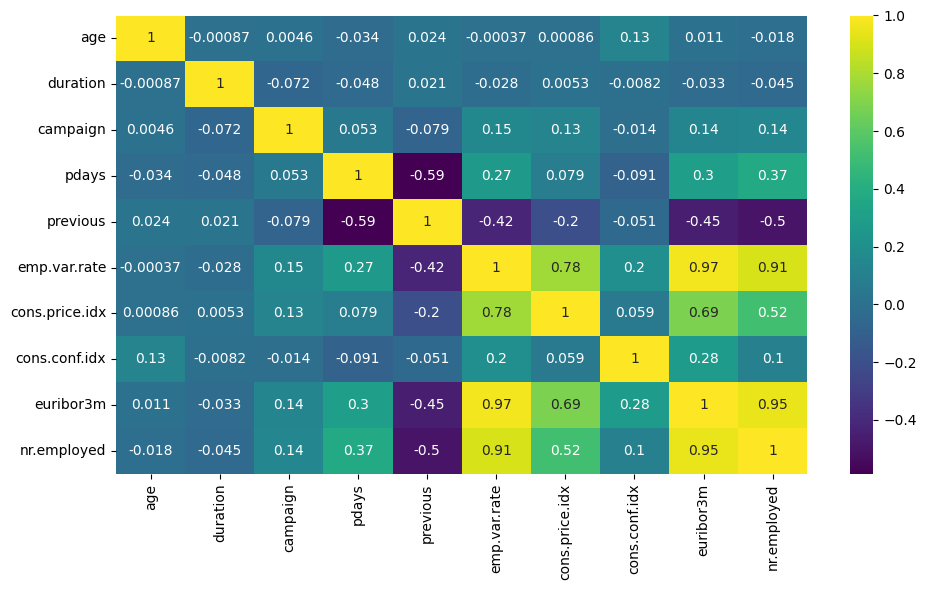

In [25]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='viridis')
plt.savefig('data/heatmap_numeric.png')

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

<b><p>Real-world data were collected from a Portuguese marketing campaign related with bank deposit subscription. The business goal is to find a model that can explain success of a contact, i.e. if the client subscribes the deposit. 

Such model can increase campaign efficiency by identifying the main characteristics that affect success, helping in a better management of the available resources (e.g. human effort, phone calls, time) and selection of a high quality and affordable set of potential buying customers.

The analysis of the data shows campaign was not very successful in getting customers signup for long term deposit product.

From a business perspective for marketing team, the main task of this ML project is to determine the factors, features or feature interactions which could lead to a higher rate of success.
</p>
</b>

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [27]:
# df = pd.read_csv('data/bank-additional-full.csv', sep = ';')
# df.rename(columns={'y': 'deposit'}, inplace=True)
# df.head()

In [28]:
# Function to perform column transformation 
def columns_transformation(df):
    ohe_cols = ['job', 'marital', 'contact', 'month', 'day_of_week', 'poutcome']
    default_order = [['yes', 'unknown', 'no']]
    housing_order = [['no', 'unknown', 'yes']]
    loan_order = [['no', 'unknown', 'yes']]
    education_order = [[
        'illiterate',
        'basic.4y',
        'basic.6y',
        'basic.9y',
        'high.school',
        'professional.course',
        'university.degree',
        'unknown'
    ]]
    
    preprocessor = ColumnTransformer(transformers=[
        ('default_ord', OrdinalEncoder(categories=default_order, handle_unknown='use_encoded_value', unknown_value=-1), ['default']),
        ('housing_ord', OrdinalEncoder(categories=housing_order, handle_unknown='use_encoded_value', unknown_value=-1), ['housing']),
        ('loan_ord', OrdinalEncoder(categories=loan_order, handle_unknown='use_encoded_value', unknown_value=-1), ['loan']),
        ('edu_ord', OrdinalEncoder(categories=education_order, handle_unknown='use_encoded_value', unknown_value=-1), ['education']),
        ('ohe', OneHotEncoder(handle_unknown='ignore'), ohe_cols),
    ], remainder='passthrough')
    
    preprocessor.fit(df)
    transformed_df = preprocessor.transform(df)
    new_df = pd.DataFrame(transformed_df, columns=preprocessor.get_feature_names_out())
    
    final_col = []
    for col in new_df.columns:
        new_df.rename(columns={col: col.split('__')[1]}, inplace=True)
    
    le = LabelEncoder()
    new_df['deposit'] = le.fit_transform(df['deposit'])
    return new_df

new_df = columns_transformation(df)
new_df.head()

,default,housing,loan,education,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,deposit
0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
1,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
2,2.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
3,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0
4,2.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0


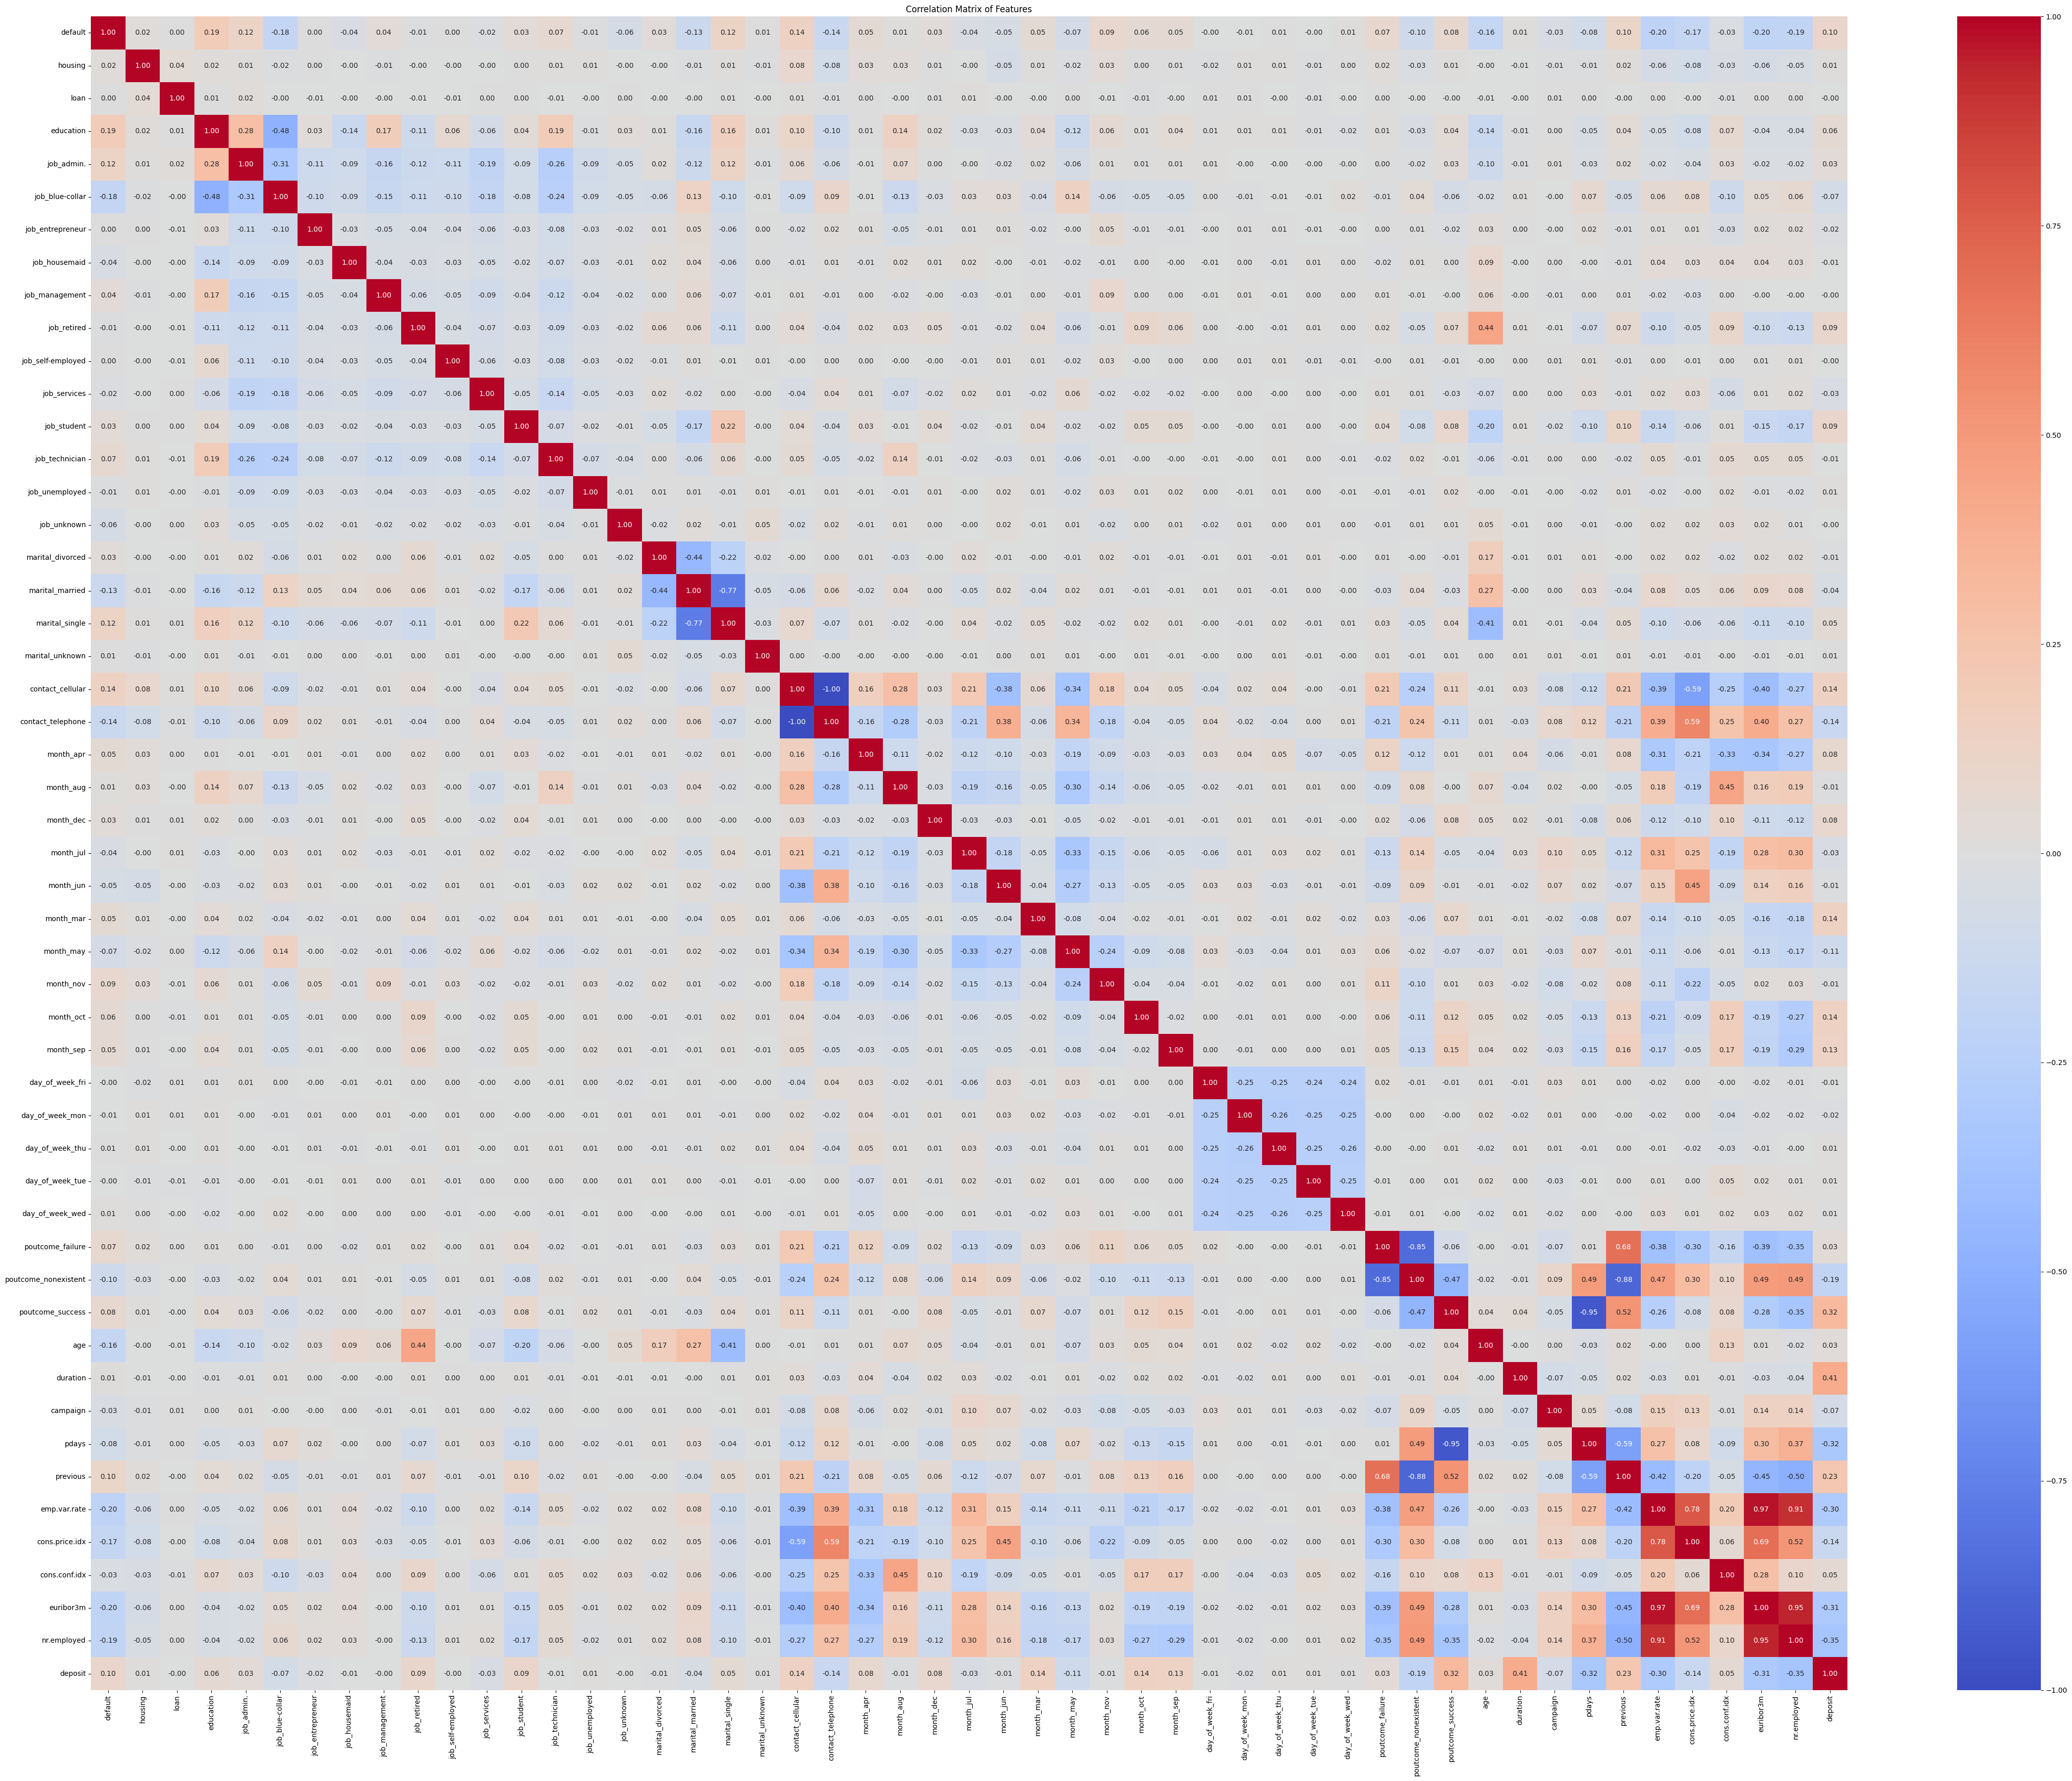

In [29]:
plt.figure(figsize=(45, 35))

# Plot heatmap  
sns.heatmap(new_df.corr(), annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

plt.title('Correlation Matrix of Features')
plt.show()

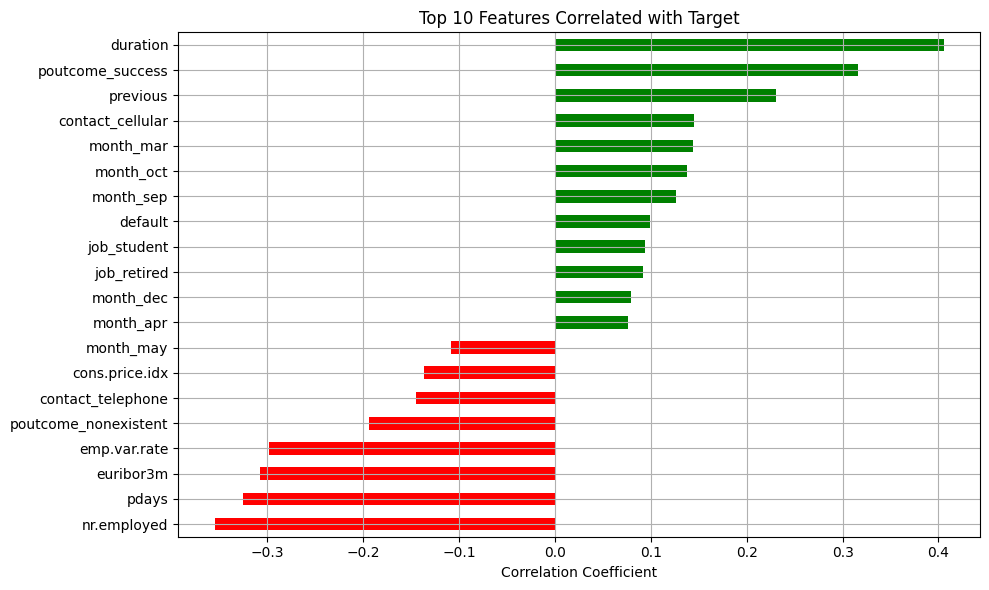

In [30]:
#  Correlation of features with deposit
correlations = new_df.corr()['deposit'].drop('deposit')   

#  Select top 10 by absolute value 
top_features = correlations.abs().sort_values(ascending=False).head(20).index
top_10_corr = correlations[top_features]   


top_10_corr = top_10_corr.sort_values()
colors = ['green' if val > 0 else 'red' for val in top_10_corr]

plt.figure(figsize=(10, 6))
top_10_corr.sort_values().plot(kind='barh', color=colors)
plt.title('Top 10 Features Correlated with Target')
plt.xlabel('Correlation Coefficient')
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
X = new_df.drop('deposit', axis=1)
y = new_df['deposit']

X.head()

,default,housing,loan,education,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0
1,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0
2,2.0,2.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0
3,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0
4,2.0,0.0,2.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [33]:
X_train.shape, X_test.shape

((32950, 50), (8238, 50))

In [34]:
y_test

14455    0
36380    0
40076    0
10778    0
27939    0
        ..
33359    1
34998    0
39861    0
3920     0
33395    0
Name: deposit, Length: 8238, dtype: int64

In [35]:
y_train

25611    0
26010    0
40194    1
297      0
36344    0
        ..
40205    0
27316    0
14392    0
7494     0
10747    0
Name: deposit, Length: 32950, dtype: int64

In [36]:
X_test.head()

,default,housing,loan,education,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,...,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
14455,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,...,32,131,5,999,0,1.4,93.918,-42.7,4.961,5228.1
36380,2.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37,100,1,999,0,-2.9,92.963,-40.8,1.262,5076.2
40076,1.0,2.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,...,73,131,2,999,0,-1.7,94.215,-40.3,0.81,4991.6
10778,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,44,48,2,999,0,1.4,94.465,-41.8,4.961,5228.1
27939,2.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,...,28,144,2,999,0,-1.8,92.843,-50.0,1.531,5099.1


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [37]:
estimators = ['DummyClassifier', 'LogisticRegression', 'DecisionTree', 'KNN', 'SVM']
fit_time = []
test_accuracy = []
train_accuracy = []
precision = []
recall = []
f1 = []
best_params = []

In [38]:
# Pipeline for baseline model
dummy_pipe = Pipeline ([
    ('scale', StandardScaler(with_mean=False)),
    ('model', DummyClassifier(random_state=42, strategy='stratified'))
])

In [39]:
dummy_start_time = time.time()

dummy_pipe.fit(X_train, y_train)
baseline_preds = dummy_pipe.predict(X_test)

dummy_end_time = time.time()
dummy_time_taken = dummy_end_time - dummy_start_time

dummy_train_accuracy = accuracy_score(y_train, dummy_pipe.predict(X_train))
dummy_test_accuracy = accuracy_score(y_test, baseline_preds)
dummy_precision = precision_score(y_test, baseline_preds, average='macro')
dummy_recall = recall_score(y_test, baseline_preds, average='macro')
dummy_f1 = f1_score(y_test, baseline_preds, average='macro')

fit_time.append(dummy_time_taken)
train_accuracy.append(dummy_train_accuracy)
test_accuracy.append(dummy_test_accuracy)
precision.append(dummy_precision)
recall.append(dummy_recall)
f1.append(dummy_f1)

print(f'Total time: {dummy_time_taken}')
print("Train Accuracy: {:.6f}".format(dummy_train_accuracy))
print("Test Accuracy: {:.6f}".format(dummy_test_accuracy))
print("Precision: {:.6f}".format(dummy_precision))
print("Recall: {:.6f}".format(dummy_recall))
print("F1-score: {:.6f}".format(dummy_f1))

Total time: 0.16281390190124512
Train Accuracy: 0.800243
Test Accuracy: 0.803714
Precision: 0.505169
Recall: 0.505086
F1-score: 0.505122


<p>A confusion matrix is a table used to evaluate the performance of a classification model. It shows the number of correct and incorrect predictions made by the model compared to the actual outcomes.

Confusion Matrix Structure (Binary Classification)</b>

|                       | Predicted: Negative (0) | Predicted: Positive (1) |
|:----------------------|:------------------------|:-------------------------|
| Actual: Negative (0)  | True Negative (TN)      | False Positive (FP)     |
| Actual: Positive (1)  | False Negative (FN)     | True Positive (TP)      |

The main diagonal of the matrix represents the correct predictions, while the off-diagonal elements represent the incorrect predictions. The overall performance of the model can be calculated by using metrics like accuracy, precision, recall and F1-score by combining the values of TP, FP, TN and FN.
</p>

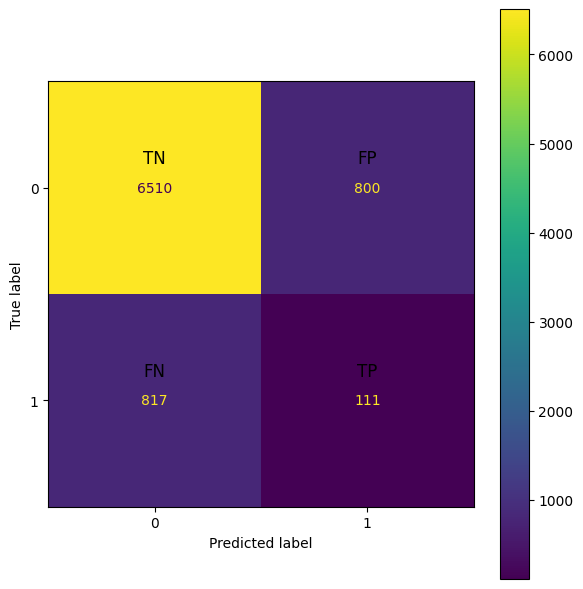

In [40]:
show_confusion_matrix(y_test, baseline_preds)

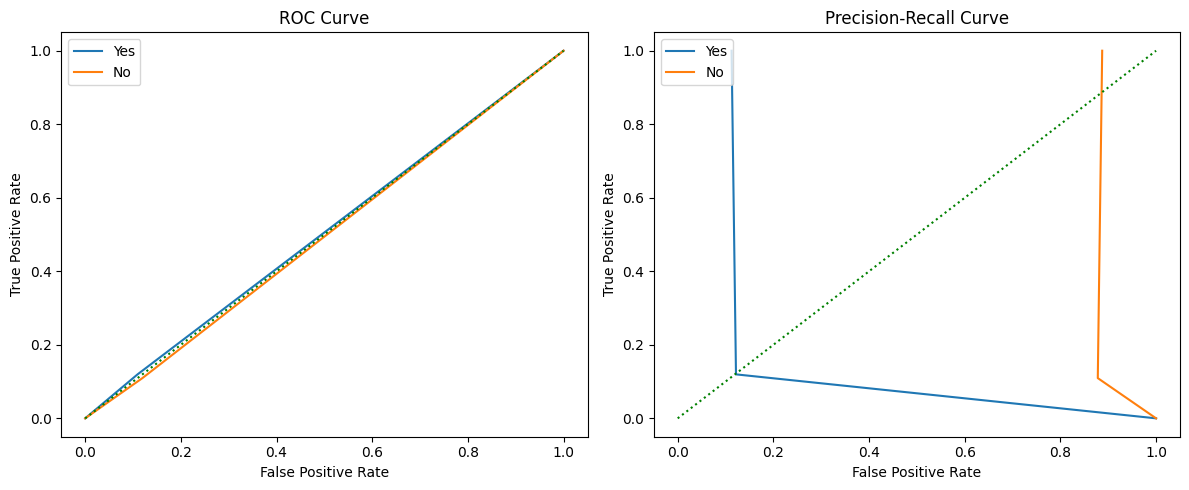

In [41]:
show_metrics_curve(dummy_pipe)

<p>
A Confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted by the ML model. A good model is one which has high TP and TN values, while low FP and FN values.

Above confusion matrix for DummyClassifier has a high value of TP rates but low value of TN. Accuracy rate of 0.80 seems good but misleading. Higher values of FP and FN indicates that the model performance is below average and class populations is not balanced.

* A low recall score (< 0.5) means your classifier has a high number of False negatives which can be an outcome of imbalanced class or untuned model hyperparameters.
* A low precision score (< 0.5) means your classifier has a high number of False positives which can be an outcome of imbalanced class or untuned model hyperparameters.

Confusion matrix above is slightly counter intuitive because this data set is heavily weighted towards customers who said No to the long term product, hence the No as the True Negative above with a value of 9763.
</p>

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [42]:
# Pipeline for LogisticRegression model
lr_pipe = Pipeline ([
    ('scale', StandardScaler(with_mean=False)),
    ('model', LogisticRegression(random_state=42, max_iter=10000))
])

lr_start_time = time.time()

lr_pipe.fit(X_train, y_train)
lr_preds = lr_pipe.predict(X_test)

lr_end_time = time.time()
lr_time_taken = lr_end_time - lr_start_time

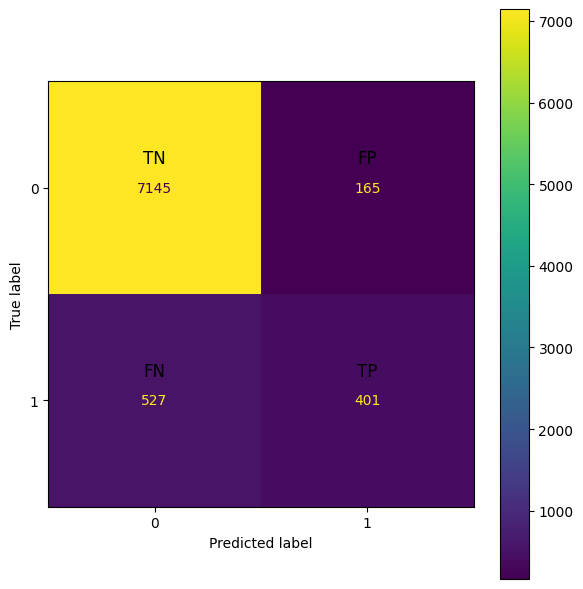

In [43]:
show_confusion_matrix(y_test, lr_preds)

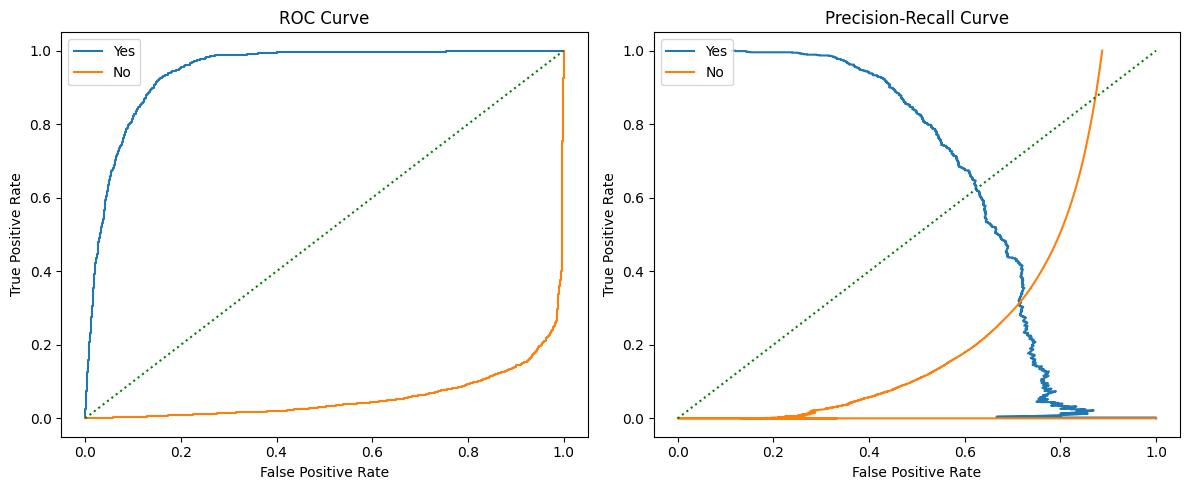

In [44]:
show_metrics_curve(lr_pipe)

In [45]:
# Check area under the curve auc for our model
print_auc(lr_pipe)

Area under curve is 0.940000


<b>With the ROC plot above, deposit = Yes is closer to top-left corner of the plt that indicates better performance than the Deposit = No. With the ROC AUC score of 0.75 which is over 0.5, this means that the classifer can detect more numbers of True positives and True negatives than False negatives and False positives.</b>

### Problem 9: Score the Model

What is the accuracy of your model?

In [46]:
# Collect metrics for LogisticRegression Classifier
lr_train_accuracy = accuracy_score(y_train, lr_pipe.predict(X_train))
lr_test_accuracy = accuracy_score(y_test, lr_preds)
lr_precision = precision_score(y_test, lr_preds, average='macro')
lr_recall = recall_score(y_test, lr_preds, average='macro')
lr_f1 = f1_score(y_test, lr_preds, average='macro')

fit_time.append(lr_time_taken)
train_accuracy.append(lr_train_accuracy)
test_accuracy.append(lr_test_accuracy)
precision.append(lr_precision)
recall.append(lr_recall)
f1.append(lr_f1)

print(f'Total time: {lr_time_taken}')
print("Train Accuracy: {:.6f}".format(lr_train_accuracy))
print("Test Accuracy: {:.6f}".format(lr_test_accuracy))
print("Precision: {:.6f}".format(lr_precision))
print("Recall: {:.6f}".format(lr_recall))
print("F1-score: {:.6f}".format(lr_f1))

Total time: 0.5711627006530762
Train Accuracy: 0.910106
Test Accuracy: 0.915999
Precision: 0.819895
Recall: 0.704770
F1-score: 0.745313


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [47]:
# Pipeline for DecisionTreeClassifier model
dt_pipe = Pipeline ([
    ('scale', StandardScaler(with_mean=False)),
    ('model', DecisionTreeClassifier(random_state=42))
])

dt_start_time = time.time()

dt_pipe.fit(X_train, y_train)
dt_preds = dt_pipe.predict(X_test)

dt_end_time = time.time()
dt_time_taken = dt_end_time - dt_start_time

dt_train_accuracy = accuracy_score(y_train, dt_pipe.predict(X_train))
dt_test_accuracy = accuracy_score(y_test, dt_preds)
dt_precision = precision_score(y_test, dt_preds, average='macro')
dt_recall = recall_score(y_test, dt_preds, average='macro')
dt_f1 = f1_score(y_test, dt_preds, average='macro')

fit_time.append(dt_time_taken)
train_accuracy.append(dt_train_accuracy)
test_accuracy.append(dt_test_accuracy)
precision.append(dt_precision)
recall.append(dt_recall)
f1.append(dt_f1)

print(f'Total time: {dt_time_taken}')
print("Train Accuracy: {:.6f}".format(dt_train_accuracy))
print("Test Accuracy: {:.6f}".format(dt_test_accuracy))
print("Precision: {:.6f}".format(dt_precision))
print("Recall: {:.6f}".format(dt_recall))
print("F1-score: {:.6f}".format(dt_f1))

Total time: 0.32634425163269043
Train Accuracy: 1.000000
Test Accuracy: 0.894999
Precision: 0.737547
Recall: 0.740447
F1-score: 0.738984


In [48]:
# Pipeline for KNeighborsClassifier model
knn_pipe = Pipeline ([
    ('scale', StandardScaler(with_mean=False)),
    ('model', KNeighborsClassifier())
])

knn_start_time = time.time()

knn_pipe.fit(X_train, y_train)
knn_preds = knn_pipe.predict(X_test)

knn_end_time = time.time()
knn_time_taken = knn_end_time - knn_start_time

knn_train_accuracy = accuracy_score(y_train, knn_pipe.predict(X_train))
knn_test_accuracy = accuracy_score(y_test, knn_preds)
knn_precision = precision_score(y_test, knn_preds, average='macro')
knn_recall = recall_score(y_test, knn_preds, average='macro')
knn_f1 = f1_score(y_test, knn_preds, average='macro')

fit_time.append(knn_time_taken)
train_accuracy.append(knn_train_accuracy)
test_accuracy.append(knn_test_accuracy)
precision.append(knn_precision)
recall.append(knn_recall)
f1.append(knn_f1)

print(f'Total time: {knn_time_taken}')
print("Train Accuracy: {:.6f}".format(knn_train_accuracy))
print("Test Accuracy: {:.6f}".format(knn_test_accuracy))
print("Precision: {:.6f}".format(knn_precision))
print("Recall: {:.6f}".format(knn_recall))
print("F1-score: {:.6f}".format(knn_f1))

Total time: 0.7116737365722656
Train Accuracy: 0.921608
Test Accuracy: 0.899612
Precision: 0.758099
Recall: 0.654612
F1-score: 0.688279


In [49]:
# Pipeline for SVM model
svm_pipe = Pipeline ([
    ('scale', StandardScaler(with_mean=False)),
    ('model', SVC(kernel='rbf'))
])

svm_start_time = time.time()

svm_pipe.fit(X_train, y_train)
svm_preds = svm_pipe.predict(X_test)

svm_end_time = time.time()
svm_time_taken = svm_end_time - svm_start_time

svm_train_accuracy = accuracy_score(y_train, svm_pipe.predict(X_train))
svm_test_accuracy = accuracy_score(y_test, svm_preds)
svm_precision = precision_score(y_test, svm_preds, average='macro')
svm_recall = recall_score(y_test, svm_preds, average='macro')
svm_f1 = f1_score(y_test, svm_preds, average='macro')

fit_time.append(svm_time_taken)
train_accuracy.append(svm_train_accuracy)
test_accuracy.append(svm_test_accuracy)
precision.append(svm_precision)
recall.append(svm_recall)
f1.append(svm_f1)

print(f'Total time: {svm_time_taken}')
print("Test Accuracy: {:.6f}".format(svm_test_accuracy))
print("Train Accuracy: {:.6f}".format(svm_train_accuracy))
print("Precision: {:.6f}".format(svm_precision))
print("Recall: {:.6f}".format(svm_recall))
print("F1-score: {:.6f}".format(svm_f1))

Total time: 13.729768991470337
Test Accuracy: 0.897791
Train Accuracy: 0.897329
Precision: 0.783110
Recall: 0.589142
F1-score: 0.620441


In [51]:
metrics_df = pd.DataFrame({
    'Model': estimators,
    'Train Time': fit_time,
    'Train Accuracy': train_accuracy,
    'Test Accuracy': test_accuracy
})
pd.set_option('display.max_colwidth', None)
metrics_df

,Model,Train Time,Train Accuracy,Test Accuracy
0,DummyClassifier,0.162814,0.800243,0.803714
1,LogisticRegression,0.571163,0.910106,0.915999
2,DecisionTree,0.326344,1.000000,0.894999
3,KNN,0.711674,0.921608,0.899612
4,SVM,13.729769,0.897329,0.897791


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

##### Questions